In [51]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")    # modify the path based on your notebook location

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import pipit as pp
import pandas as pd
from pipit.partitions import Event, Partition, get_partition_graph

In [53]:
trace = pp.Trace.from_otf2("/home/rakrish/trace-data/sw4lite-32/")
trace._match_mpi()

In [54]:
trace.events

,Timestamp (ns),Event Type,Name,Thread,Process,Attributes,_matching_event,_matching_timestamp
0,4.772924e-01,Instant,ProgramBegin,0,14,{'program_name': '/g/g92/bhowmik1/sw4lite/sw4l...,<NA>,NaN
1,1.484379e+02,Instant,ProgramBegin,0,15,{'program_name': '/g/g92/bhowmik1/sw4lite/sw4l...,<NA>,NaN
2,1.740208e+03,Instant,ProgramBegin,0,12,{'program_name': '/g/g92/bhowmik1/sw4lite/sw4l...,<NA>,NaN
3,2.002576e+04,Instant,ProgramBegin,0,13,{'program_name': '/g/g92/bhowmik1/sw4lite/sw4l...,<NA>,NaN
4,2.014269e+04,Enter,MPI_Init,0,14,{'region': 'Region 36'},<NA>,NaN
...,...,...,...,...,...,...,...,...
9533,4.699147e+09,Leave,MPI_Sendrecv,0,25,None,<NA>,NaN
9534,4.704243e+09,Leave,TRACER_Loop,0,25,None,<NA>,NaN
9535,4.704245e+09,Instant,MeasurementOnOff,0,25,{'measurement_mode': 'MeasurementMode.OFF'},<NA>,NaN
9536,4.704403e+09,Leave,TRACER_Loop,0,1,None,<NA>,NaN


In [55]:
# Create event graph (linked list)

# Visualise Event Graph
#from graphviz import Digraph

# Function to create a DOT representation of linked lists
def linked_lists_to_dot(start_event_ids, dict):
    dot = Digraph(comment='Process Event Graph')

    for i, se in enumerate(start_event_ids):
        current_node = dict[se]
        while current_node:
            dot.node(f"{current_node.event_id}_{current_node.event_name}", str(current_node.event_name) + ":" + str(current_node.event_id))
            if current_node.get_next_event():
                dot.edge(f"{current_node.event_id}_{current_node.event_name}", f"{current_node.get_next_event().event_id}_{current_node.get_next_event().event_name}")

            if current_node.event_name == 'MpiSend' and current_node.has_matching_event():
                dot.edge(f"{current_node.event_id}_{current_node.event_name}", f"{current_node.get_matching_event().event_id}_{current_node.get_matching_event().event_name}")
            current_node = current_node.get_next_event()

    return dot

# Create a DOT representation
#dot_representation = linked_lists_to_dot(start_event_ids, event_dict)
#dot_representation.attr(rankdir='LR')  
# Display the DOT representation in a Jupyter Notebook (optional)
#dot_representation

In [56]:
# Create partition graph (i.e. merge send-receives and SCC)
start_partition_ids, partition_dict = get_partition_graph(trace)
print (start_partition_ids)


for paritition_id, partition in partition_dict.items():
    print (f"{partition.partition_id} - {partition.event_dict}")


Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped event - MeasurementOnOff
Skipped ev

In [45]:
# Display initial partition graph (before SCC)

from graphviz import Digraph

# Function to create a DOT representation of linked lists
def visualise(start_ids, partition_dict, dot=None):
    visited = []
    def visualise_recursive(start_ids, partition_dict, dot):
        nonlocal visited
        if dot is None:
            dot = Digraph(comment='Partition Graph')

        for i, sp in enumerate(start_ids):
            current_partition = partition_dict[sp]
            if current_partition.partition_id in visited:
                return dot
            dot.node(f"{current_partition.partition_id}", str(current_partition.partition_id))
            visited.append(current_partition.partition_id)
            children_ids = current_partition.get_children()
            for child_id in children_ids:
                child_partition = partition_dict[child_id]
                dot = visualise_recursive([child_id], partition_dict, dot)
                dot.edge(f"{current_partition.partition_id}", f"{child_partition.partition_id}")
        return dot
    return visualise_recursive(start_ids, partition_dict, dot)

 # Sample linked lists

# Create a DOT representation
dot_representation = visualise(start_partition_ids, partition_dict)
dot_representation.attr(rankdir='LR')  
# Display the DOT representation in a Jupyter Notebook (optional)
dot_representation

KeyboardInterrupt: 

In [57]:
# merge SCC

components = Partition.tarjan_strongly_connected(partition_dict)
print (components)

[[2110], [2069], [2028], [1987], [1946], [1905], [1864], [1863], [1904], [1945], [1986], [1782], [1701], [1620], [1539], [1458], [1377], [1296], [1295], [1376], [1457], [1538], [1537], [1174], [1093], [1012], [931], [850], [769], [688], [687], [768], [849], [930], [929], [566], [485], [404], [323], [242], [161], [80], [79], [160], [241], [322], [321], [320], [928], [1536], [1619], [2027], [1618], [1011], [1010], [403], [402], [401], [1009], [1617], [1700], [2068], [1699], [1092], [1091], [484], [483], [482], [1090], [1698], [2109], [1781], [1780], [1173], [1172], [565], [564], [563], [1171], [1779], [1823], [1215], [607], [606], [1214], [1822], [1778], [1697], [1616], [1535], [1456], [848], [240], [239], [847], [1455], [1454], [1375], [767], [159], [158], [766], [1374], [1373], [1294], [686], [78], [77], [685], [1293], [1292], [1291], [1372], [1453], [2108], [2067], [2026], [1985], [1944], [1903], [1862], [1861], [1902], [1943], [1452], [1170], [1089], [1008], [927], [846], [765], [684

In [58]:
partition_dict = Partition.merge_strongly_connected_components(partition_dict, components)
for sid in start_partition_ids:
    if sid not in partition_dict:
        print ("Something is wrong")

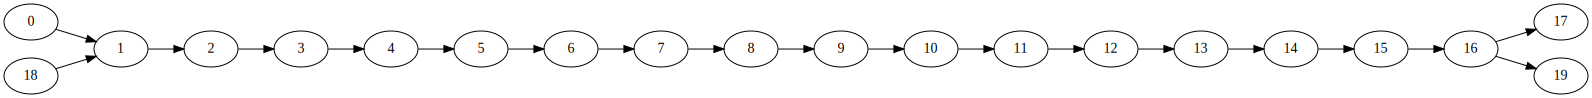

In [22]:
dot_representation = visualise(start_partition_ids, partition_dict)
dot_representation.attr(rankdir='LR') 
dot_representation

In [59]:
# Leap partitions
def print_leaps(dag):
    for i, leap in enumerate(dag.leaps):
        if len(leap.partitions_ids) < 1:
            continue
        print('Leap', i)
        print('  ', leap.partitions_ids)

In [ ]:
# Create leaps
from pipit.partitions.leap import Partition_DAG, Leap

unique_processes = trace.events['Process'].unique()

# root_partitions = []
# for root_id in start_partition_ids:
#     root_partitions.append(partition_dict[root_id])
#     print(root_id)
#     print(partition_dict[root_id].partition_id)

print("Creating partition DAG")

dag = Partition_DAG(root_partitions, partition_dict, set(unique_processes))

print("Creating dag")

dag.create_dag()

print("calculating distance") 

dag.calculate_distance()

pring("creating leaps")

# dag.create_leaps()


Creating partition DAG
Creating dag
calculating distance
There are  32  roots in here
Root number  0
processing  1
processing  2
processing  610
processing  1218
processing  1825
processing  1826
processing  1867
processing  1908
processing  1949
processing  1464
processing  856
processing  248
processing  249
processing  857
processing  1465
processing  1466
processing  1385
processing  1304
processing  1305
processing  1306
processing  698
processing  90
processing  91
processing  699
processing  1307
processing  1308
processing  1227
processing  1228
processing  1309
processing  1390
processing  1471
processing  1472
processing  864
processing  256
processing  257
processing  865
processing  1473
processing  1954
processing  1913
processing  1872
processing  1873
processing  1314
processing  706
processing  98
processing  99
processing  707
processing  1315
processing  1874
processing  1833
processing  1834
processing  1875
processing  1916
processing  1957
processing  1480
processi

In [50]:
# Leaps before completion
print_leaps(dag)

AttributeError: 'Partition_DAG' object has no attribute 'leaps'

In [28]:
# Complete leaps
dag.complete_leaps(force_merge=False)

merging partition 17 to leap 16
merging partition 19 to leap 16


In [29]:
# Leaps after completion
print_leaps(dag)

Leap 0
   {0, 18}
Leap 16
   {17, 19}


In [30]:
# Global/local step assignment
dag.global_step_assignment()

No cycle found.
No cycle found.


In [33]:
dag.calculate_lateness()
dag.calculate_differential_lateness()

# quick fix for now - this won't be needed once all operations are taken into account
df = dag.global_step_df
df.loc[df['EventName'] == 'ProgramBegin', 'Lateness'] = 0.0
df.loc[df['EventName'] == 'ProgramBegin', 'DiffLateness'] = 0.0

display(dag.global_step_df.head(10))

,PartitionId,EventId,EventName,Stride,NextStride,Process,Matching Event ID,Step,Matching Step,Matching Process,Lateness,DiffLateness
0,0,3,ProgramBegin,0,1,0,-1,0,NaN,NaN,0.0,0.0
1,18,0,ProgramBegin,0,1,1,-1,0,NaN,NaN,0.0,0.0
2,0,17,MpiSend,1,2,0,21,1,2.0,1.0,0.0,0.0
3,0,21,MpiRecv,2,2,1,17,2,1.0,0.0,0.0,0.0
4,0,24,MpiSend,2,3,1,26,3,4.0,0.0,0.0,0.0
5,0,26,MpiRecv,3,3,0,24,4,3.0,1.0,0.0,0.0
6,0,30,MpiSend,3,4,0,32,5,6.0,1.0,0.0,0.0
7,0,32,MpiRecv,4,4,1,30,6,5.0,0.0,0.0,0.0
8,0,36,MpiSend,4,5,1,38,7,8.0,0.0,0.0,0.0
9,0,38,MpiRecv,5,5,0,36,8,7.0,1.0,0.0,0.0


In [36]:
def lateness_vis(df, coloring_field: str = 'EventName'):
    from bokeh.transform import linear_cmap
    from bokeh.models import ColumnDataSource, HoverTool
    import bokeh
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.models import ColumnDataSource
    from bokeh.transform import factor_cmap, dodge
    from bokeh.palettes import Spectral5

    output_notebook()

    p = figure(title = "Trace", sizing_mode="stretch_width", height=200, tools="hover") 
    source = ColumnDataSource(df)
    p.y_range.flipped = True  # Flip the y-axis
    # index_cmap = factor_cmap('EventName', 
    #                          palette=Spectral5, 
    #                          factors=sorted(df['EventName'].unique()))

    
    if coloring_field == 'EventName':
        index_cmap = factor_cmap('EventName', 
                                palette=Spectral5, 
                                factors=sorted(df['EventName'].unique()))

    else:
        metric = df[coloring_field]
        # average = metric.mean()
        # std_dev = metric.std()
        # high = average
        # high = average + (std_dev / 16)
        # low = average -  std_dev
        # low = max(low, 0)

        high = df[coloring_field].max()
        low = df[coloring_field].min()
        # pallete = bokeh.palettes.cividis(100)
        # pallete = bokeh.palettes.Plasma256
        # pallete = bokeh.palettes.Turbo256
        pallete = bokeh.palettes.RdYlGn11
        # pallete = bokeh.palettes.Greys256[::-1]
        index_cmap = linear_cmap(coloring_field, low=low, high=high, palette=pallete)
        # print('min', df[coloring_field].min())
        # print('max', df[coloring_field].max())
        # print('low',low)
        # print('high',high)

    hover = HoverTool(tooltips=[("Process", "@Process"), ("Step", "@Step"), ("Lateness", "@Lateness")])
    p.add_tools(hover)  


    p.hbar(source=source,
        y="Process",
        right=dodge("Step", 1),
        left="Step",
        height=0.5,
        line_color="black",
        fill_color=index_cmap)

    p.segment(source=source,
            y0="Process",
            x1=dodge("Matching Step", 0.5),
            x0=dodge("Step", 0.5),
            y1="Matching Process", 
            color="black")
    p.yaxis.ticker = bokeh.models.FixedTicker(ticks=list(df['Process'].unique()))


    show(p) 

In [38]:
lateness_vis(df)

Loading BokehJS ...

In [39]:
lateness_vis(df, coloring_field='Lateness')

Loading BokehJS ...

In [40]:
lateness_vis(df, coloring_field='DiffLateness')

Loading BokehJS ...